In [1]:
import matplotlib.pyplot as plt, matplotlib
from matplotlib.lines import Line2D 
from astropy.io import fits
import pandas as pd, numpy as np, os, keras
from numpy import asarray
from PIL import Image
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Dropout, InputLayer, Input)
from keras.models import Model
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold 
from keras.optimizers import RMSprop

#clear keras backend
keras.backend.clear_session()

In [2]:
def create_dataset(img_folder):
    #from PIL import Image
    from keras.preprocessing import image
    img_data_array=[]
    filenames=[] #need to keep track of what order images are in
    for i, file in enumerate(os.listdir(img_folder)):
        if '.png' in file: 
            img = image.load_img(img_folder+'/'+file, target_size=(232,232,1))
            img = image.img_to_array(img)
            img /= 255
            img_data_array.append(img)
        filenames.append(file)

    return img_data_array, filenames

def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 0))  # outward by 0 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

from SDSSRM_11_Pix_Filter_Trevor import pixel_filter
plt.rcParams['axes.xmargin'] = 0 #turn off whitespace in plots

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)

In [3]:
PIL_img_data, filenames = create_dataset("spectra")
training_data = np.array(PIL_img_data)
training_data.shape

(2000, 232, 232, 3)

In [4]:
earlystop = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

# earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
#                                         mode ="min", patience = 5,  
#                                         restore_best_weights = True) 
  

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
checkpoints = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', cooldown=0, min_lr=0)

#split data
X_train,X_test,X_train,X_test = train_test_split(training_data, training_data,
                                                             test_size=0.2, random_state=13, 
                                                             shuffle=True)
print(len(X_train))
print(len(X_test))

1600
400


In [5]:
#working autoencoder

input_img = Input(shape=(232, 232, 3), name="input")
code_size=32   #dimensions of the encodings to be outputted from encoder

#ENCODER
enc_conv1 = Conv2D(12, (3, 3), activation='relu', padding='same', name='enc_conv1')(input_img)
enc_pool1 = MaxPooling2D((2, 2), padding='same', name='enc_pool1')(enc_conv1)
enc_conv2 = Conv2D(8, (4, 4), activation='relu', padding='same', name='enc_conv2')(enc_pool1)
enc_pool2 = MaxPooling2D((4, 4), padding='same', name='enc_pool2')(enc_conv2)
enc_flatten = Flatten(name='enc_flatten')(enc_pool2)
#enc_dense1 = Dense(3364, activation="relu",name = 'enc_dense1')(enc_flatten)
bottleneck = Dense(code_size, name='bottleneck')(enc_flatten) #no activation fcn for last dense layer

#DECODER
#dec_dense1 = Dense(3364, activation="relu",name = 'dec_dense5')(bottleneck)
dec_dense1 = Dense(6728, activation="relu",name = 'dec_dense1')(bottleneck)
dec_reshape = Reshape((29,29,8), name='dec_reshape')(dec_dense1)
dec_conv1 = Conv2D(8, (4, 4), activation='relu', padding='same', name='dec_conv1')(dec_reshape)
dec_upsample1 = UpSampling2D((4, 4), name='dec_upsample1')(dec_conv1)
dec_conv2 = Conv2D(12, (3, 3), padding='same', name='dec_conv2')(dec_upsample1) #no activation fcn for last conv layer
dec_upsample2 = UpSampling2D((2, 2), name='dec_upsample2')(dec_conv2)
dec_output = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='output')(dec_upsample2) #gets back to 232x232x3

#build autoencoder
autoencoder = Model(input_img, dec_output, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.summary()

#build encoder
encoder = Model(input_img, bottleneck, name='encoder')
encoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
encoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 232, 232, 3)]     0         
_________________________________________________________________
enc_conv1 (Conv2D)           (None, 232, 232, 12)      336       
_________________________________________________________________
enc_pool1 (MaxPooling2D)     (None, 116, 116, 12)      0         
_________________________________________________________________
enc_conv2 (Conv2D)           (None, 116, 116, 8)       1544      
_________________________________________________________________
enc_pool2 (MaxPooling2D)     (None, 29, 29, 8)         0         
_________________________________________________________________
enc_flatten (Flatten)        (None, 6728)              0         
_________________________________________________________________
bottleneck (Dense)           (None, 32)                

In [6]:
# def build_autoencoder(activation='relu', optimizer='rmsprop', loss='binary_crossentropy'):
#     np.random.seed(13)
#     # #original version 
#     input_img = Input(shape=(232, 232, 3), name="input")
#     code_size=32
#     #ENCODER
#     enc_conv1 = Conv2D(12, (3, 3), activation=activation, padding='same')(input_img)
#     enc_pool1 = MaxPooling2D((2, 2), padding='same')(enc_conv1)
#     enc_conv2 = Conv2D(8, (4, 4), activation=activation, padding='same')(enc_pool1)
#     enc_output = MaxPooling2D((4, 4), padding='same')(enc_conv2)
#     enc_flatten = Flatten()(enc_output)
#     bottleneck = Dense(code_size, name='bottleneck')(enc_flatten)

#     #DECODER
#     dec_dense = Dense(6728)(bottleneck)
#     dec_reshape = Reshape((29,29,8))(dec_dense)
#     dec_conv2 = Conv2D(8, (4, 4), activation=activation, padding='same')(dec_reshape)
#     dec_upsample2 = UpSampling2D((4, 4))(dec_conv2)
#     dec_conv3 = Conv2D(12, (3, 3), activation=activation, padding='same')(dec_upsample2)
#     dec_upsample3 = UpSampling2D((2, 2))(dec_conv3)
#     dec_output = Conv2D(3, (3, 3), activation='softmax', padding='same')(dec_upsample3)
    
#     autoencoder = Model(input_img, dec_output, name='autoencoder')
#     autoencoder.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
#     return autoencoder


In [7]:
# # or load old model
# autoencoder = Sequential([encoder, decoder])
# autoencoder.load_weights(checkpoint_path)

In [ ]:
#train
n_epochs, batch = 20, 256
act1, act2, opt, loss_fcn = "relu", "sigmoid", "rmsprop", "binary_crossentropy"

opt = RMSprop(lr=3e-5)

#clear keras backend
keras.backend.clear_session()

#build autoencoder
autoencoder = Model(input_img, dec_output, name='autoencoder')
autoencoder.compile(optimizer=opt, loss=loss_fcn, metrics=['accuracy'])

#build encoder
encoder = Model(input_img, bottleneck, name='encoder')
encoder.compile(optimizer=opt, loss=loss_fcn, metrics=['accuracy'])

autoencoder_train = autoencoder.fit(X_train, X_train, epochs=n_epochs,verbose=1,
  validation_data=(X_test, X_test), batch_size=batch, validation_batch_size=batch, callbacks=[reduce_lr])     #use this version since training data is split with random seed

#Model evaluation
scores = autoencoder.evaluate(X_train, X_train, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# #save weights & model
#autoencoder.save_weights('saved_models/autoencoder25_weights.h5')
autoencoder.save('saved_models/autoencoder_%s_%s_%s_%s_%d_%d.h5py' % (act1, act2, opt, loss_fcn, n_epochs, batch))

accuracy = autoencoder_train.history['accuracy']
val_accuracy = autoencoder_train.history['val_accuracy']
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(len(accuracy))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))
ax1.plot(epochs, accuracy, 'r--', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend()
ax2.plot(epochs, loss, 'r--', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend()
plt.savefig('accuracy_loss_%s_%s_%s_%s_%d_%d.pdf' % (act1, act2, opt, loss_fcn, n_epochs, batch))
plt.show()

Epoch 1/20
7/7 [==============================] - 66s 9s/step - loss: 0.6926 - accuracy: 0.8656 - val_loss: 0.6913 - val_accuracy: 0.8640
Epoch 2/20
7/7 [==============================] - 59s 8s/step - loss: 0.6902 - accuracy: 0.8648 - val_loss: 0.6882 - val_accuracy: 0.8653
Epoch 3/20
2/7 [=======>......................] - ETA: 27s - loss: 0.6879 - accuracy: 0.8650

NameError: name 'encodings' is not defined

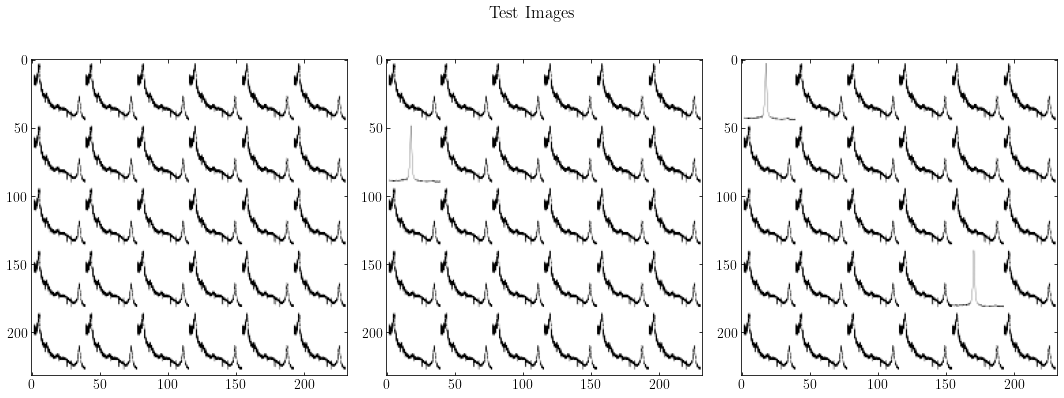

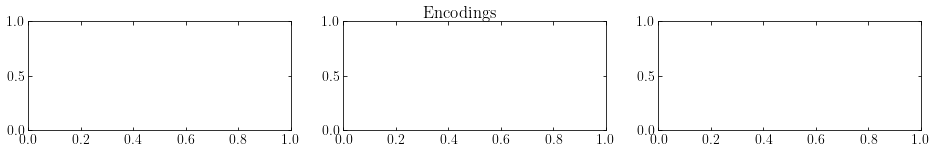

In [10]:
#visually inspect reconstructions to test accuracy

#pick random images
ncols=3
# pred = autoencoder.predict(X_train)
# encodings = encoder.predict(X_train)

# idx = np.random.randint(len(X_train), size=ncols)
# print(idx)
idx = [1498, 1432, 1202]  #indices of a same, 1diff, and 2diff spectra pages from X_train

fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15,6))
fig.suptitle('Test Images')
for i, num in enumerate(idx):
    ax[i].imshow(X_train[num, ..., 0], cmap='gray')
    #adjust_spines(ax[i], [])
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('test_images_6.pdf')

colors = [(247,252,253), (224,236,244), (191,211,230), (158,188,218), (140,150,198), 
            (140,107,177), (136,65,157), (129,15,124), (77,0,75)]
colors = np.array(colors)/256
cm = matplotlib.colors.LinearSegmentedColormap.from_list(
        'custom', colors, N=ncols)

fig, ax = plt.subplots(ncols=ncols, figsize=(16, 2))
fig.suptitle('Encodings')
for i, num in enumerate(idx):
    #code = encoder.predict(X_train[idx])[0]
    code = encodings[num]
    ax[i].imshow(code.reshape([-1, code.shape[-1]//2]), cmap=cm)
    #adjust_spines(ax[i], [])
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('encodings_6.pdf')

fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15,6))
fig.suptitle('Reconstruction of Test Images')
for i, num in enumerate(idx):
    ax[i].imshow(pred[num, ..., 0], cmap='gray')
    #adjust_spines(ax[i], [])
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('reconstructions_6.pdf')
    
    
    #plot with sigmoid over prediction output? sigmoid(x_hat_raw)
plt.show()


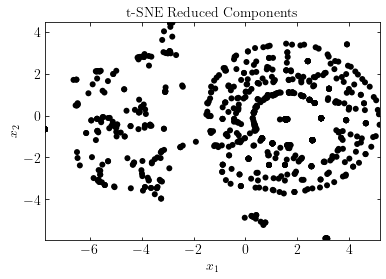

In [428]:
# t-SNE
from sklearn.manifold import TSNE
#try learning rates between 5 and 50?
lr, perp, n_iter = 300, 50, 1000
tsne = TSNE(n_components=2,learning_rate=300, perplexity=50, n_iter=1000)
X_reduced = tsne.fit_transform(encodings)

#or
#tsne_em = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(encodings)

plt.title('t-SNE Reduced Components')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.scatter(X_reduced[:,0], X_reduced[:,1], c="k", edgecolor="None")
#plt.colorbar()
plt.savefig('tsne_5_lr%d_perp%d_iter%d.pdf' % (lr, perp, n_iter))

In [377]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    fig, ax = plt.subplots(figsize=(10,10))
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    scatter = plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])  #add label for the core points for legend
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)     #outliers
    scatter2 = plt.scatter(non_cores[:, 0], non_cores[:, 1], 
                c=dbscan.labels_[non_core_mask], marker=".")   #edge points
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    title = "DBSCAN with eps=" + str(np.round(dbscan.eps,2)) +", min_samples=" + str(dbscan.min_samples)
    #title = "DBSCAN with eps=%s, min_samples=%s" % (str(np.round(dbscan.eps,2)), dbscan.min_samples)
#     print(title)
#     plt.title(title, fontsize=14)

    #make legend for the different clusters
    colormap = matplotlib.colors.Colormap('Paired')
#     legend1 = ax.legend(*scatter.legend_elements(), labels, title="Clusters", fontsize='small')
#     ax.add_artist(legend1)
    
#     legend_labels = []
#     for label in np.unique(dbscan.labels_):
#         legend_labels.append(Line2D([0], [0],
#         label=label, color=colormap(label)))
#     plt.legend(handles=legend_labels, title="Clusters", fontsize='small')
    
    
    #plt.show()
    return fig

In [128]:
#find optimal number of clusters for DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
range_n_clusters = range(2,len(X_reduced))

#X_REDUCED may have duplicate points, sklearn/cluster says number of distinct clusters is 747
best_n_clusters, best_score = 0,0
 
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_reduced)
    
    #print("Cluster_labels", cluster_labels)
    
    #silhouette score gives info on density and separation of formed clusters
    silhouette_avg = silhouette_score(X_reduced, cluster_labels)
    
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
print("Best_n_clusters", best_n_clusters)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (747) found smaller than n_clusters (748). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (747) found smaller than n_clusters (749). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (747) found smaller than n_clusters (750). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.p

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (747) found smaller than n_clusters (776). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (747) found smaller than n_clusters (777). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (747) found smaller than n_clusters (778). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.p

KeyboardInterrupt: 

In [429]:
#assume 2 clusters? similar and dissimilar

#find best hyperparameters for DBSCAN (min_samples and eps)
from sklearn.cluster import DBSCAN

#assume min_samples = best_n_clusters to find optimal eps value 
best_n_clusters = 1

range_eps = np.arange(0.01, 1, 0.01)
best_eps, best_silhouette_score = 0, 0
for eps in range_eps:
    db = DBSCAN(eps=eps, min_samples=best_n_clusters).fit(X_reduced)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    silhouette_avg = silhouette_score(X_reduced, labels)
    
    #highest silhouette score gives us best eps value
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_eps = eps
    
#now try various min_samples using this best_eps
min_samples = range(1, 500)
best_min_samples = 0
for n_samples in min_samples:
    db = DBSCAN(eps=best_eps, min_samples=n_samples).fit(X_reduced)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    
    #ignore label -1 since that is outliers
    labels = set([label for label in db.labels_ if label >= 0])

    #if len of set(labels) == best_n_clusters, min_samples value is good
    if len(set(labels)) == best_n_clusters:
        best_min_samples = n_samples
        
print("Best_eps", best_eps, "best_min_samples", best_min_samples)

Best_eps 0.21000000000000002 best_min_samples 152


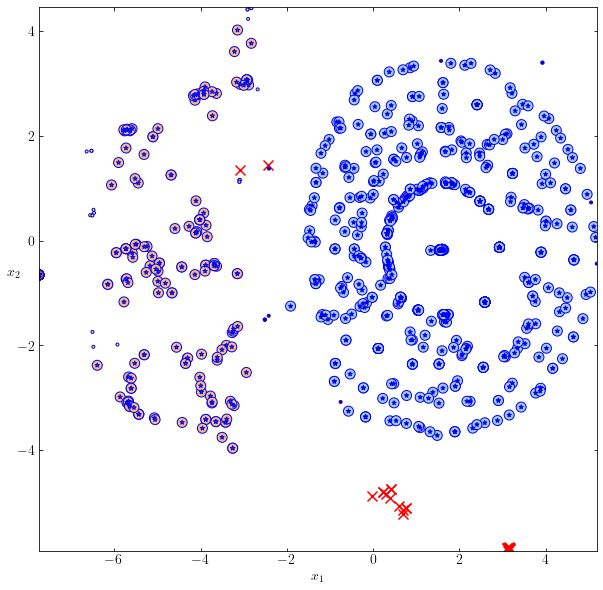

Estimated number of clusters: 3
Estimated number of outliers from any cluster: 28
Silhouette Coefficient: 0.439


In [466]:
#compute DBSCAN and plot
from sklearn.cluster import DBSCAN

best_min_samples = 15
best_eps = 1.1

db = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X_reduced)
fig = plot_dbscan(db, X_reduced, size=100)
fig.savefig('dbscan_5_eps%d_min%d_1.pdf' % (best_eps, best_min_samples))
plt.show()

#print metrics
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise_ = list(db.labels_).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of outliers from any cluster: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_reduced, db.labels_))

In [487]:
#finetune hyperparameters with RandomizedSearchCV

from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
model = KerasClassifier(build_fn = build_autoencoder)

#define parameters to test
params = {'activation': ['relu', 'leaky_relu', 'tanh', 'selu'], 'optimizer': ['sgd','adam', 'rmsprop'],
         'batch_size':[32,128,256], 'loss': ["mean_squared_error", "sgd", "binary_crossentropy"],
         'epochs': [50, 100, 200, 300, 400]} #, 'learning_rate': [0.1, 0.01, 0.001]}

# #create randomized search CV object
# random_search = RandomizedSearchCV(model, param_distributions=params, cv=KFold(3), n_iter=10)
# #fit random_search
# history = random_search.fit(X_train, X_train)

# #print score
# score = random_search.evaluate(X_train, X_train)
# print(score)

# evaluate model with Regressor
# estimator = KerasRegressor(build_fn=build_autoencoder, epochs=100, batch_size=5, verbose=0)
# kfold = KFold(n_splits=10)
# results = cross_val_score(estimator, X, Y, cv=kfold)

grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, X_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))



RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f9d31cceaf0>,
                   param_distributions={'activation': ['relu', 'leaky_relu',
                                                       'tanh', 'selu'],
                                        'batch_size': [32, 128, 256],
                                        'epochs': [50, 100, 200, 300, 400],
                                        'loss': ['mean_squared_error', 'sgd',
                                                 'binary_crossentropy'],
                                        'optimizer': ['sgd', 'adam',
                                                      'rmsprop']})


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/wrappers/scikit_learn.py", line 221, in fit
    raise ValueError('Invalid shape for y: ' + str(y.shape))
ValueError: Invalid shape for y: (640, 232, 232, 3)

  warnings.warn("Estimator fit failed. The score on this train-test"


ValueError: Invalid shape for y: (960, 232, 232, 3)

In [ ]:
#now search for best loss function and optimizer 
params = dict(loss=["mean_squared_error", "sgd", "binary_crossentropy"], optimizer=["rmsprop", "adam", "adamax"])

rand_i [ 8 16 17 11 23]


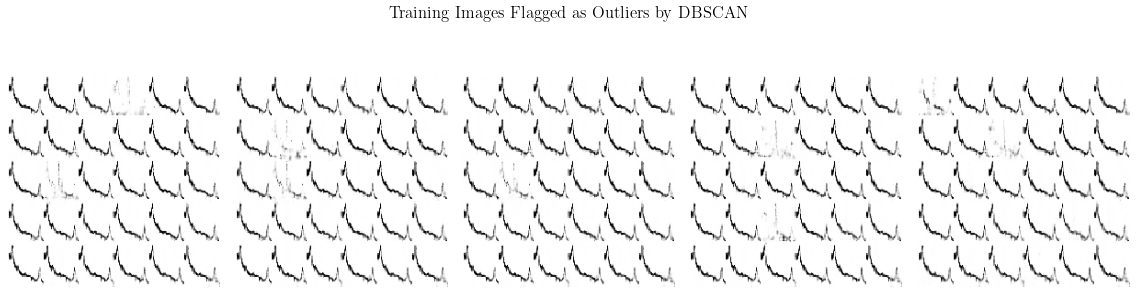

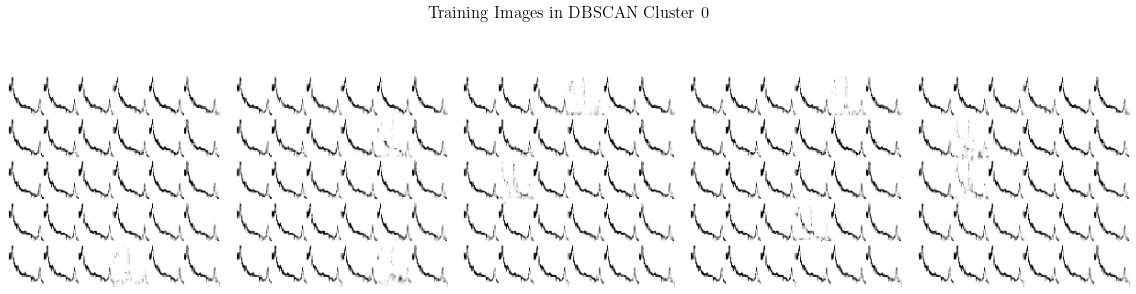

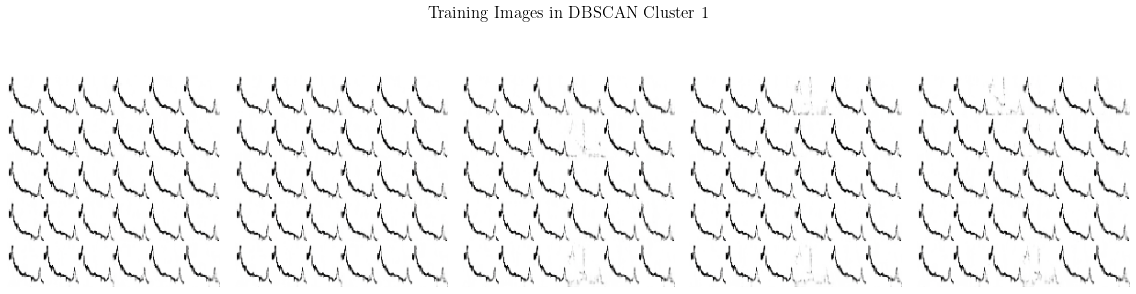

In [469]:
#visually check DBSCAN outliers

outliers, outliers_idx = [], []
for i, lab in enumerate(db.labels_):
    if lab == -1:
        outliers.append(pred[i])
        outliers_idx.append(i)
        
#plot random 5 outliers
# outliers_plot = np.random.choice(outliers, size=10)

if len(outliers) > 0:
    rand_i = np.random.randint(0, len(outliers), size=5)
    print("rand_i", rand_i)
    fig, ax = plt.subplots(ncols=5, figsize=(16,5))
    fig.suptitle('Training Images Flagged as Outliers by DBSCAN')
    for idx, i in enumerate(rand_i):   
        ax[idx].imshow(outliers[i])
        adjust_spines(ax[idx], [])
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.savefig('dbscan_5_eps%d_min%d_outliers.pdf' % (best_eps, best_min_samples))
    plt.show()


#plot random 5 images in a cluster
# points, points_idx = [], []
# for i, lab in enumerate(db.labels_):
#     if lab != -1:
#         points.append(X_train[i])
#         points_idx.append(i)
# points_i = np.random.randint(0, len(points), size=5)
# print("points_i", points_i)

# fig, ax = plt.subplots(ncols=5, figsize=(16,5))
# fig.suptitle('Training Images in DBSCAN Clusters')
# for idx, i in enumerate(points_i):
#     ax[idx].imshow(points[i])
#     adjust_spines(ax[idx], [])
# fig.tight_layout()
# fig.subplots_adjust(top=0.95)
# plt.savefig('dbscan_5_eps%d_min%d_non_outliers.pdf' % (best_eps, best_min_samples))
# plt.show()


cluster0, cluster0_idx = [], []
for i, lab in enumerate(db.labels_):
    if lab != 0:
        cluster0.append(pred[i])
        cluster0_idx.append(i)
cluster0_i = np.random.randint(0, len(cluster0), size=5)
fig, ax = plt.subplots(ncols=5, figsize=(16,5))
fig.suptitle('Training Images in DBSCAN Cluster 0')
for idx, i in enumerate(cluster0_i):   
    ax[idx].imshow(cluster0[i])
    adjust_spines(ax[idx], [])
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('dbscan_5_eps%d_min%d_cluster0_2.pdf' % (best_eps, best_min_samples))
plt.show()

cluster1, cluster1_idx = [], []
for i, lab in enumerate(db.labels_):
    if lab != 0:
        cluster1.append(pred[i])
        cluster1_idx.append(i)
cluster1_i = np.random.randint(0, len(cluster0), size=5)
fig, ax = plt.subplots(ncols=5, figsize=(16,5))
fig.suptitle('Training Images in DBSCAN Cluster 1')
for idx, i in enumerate(cluster1_i):   
    ax[idx].imshow(cluster1[i])
    adjust_spines(ax[idx], [])
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('dbscan_5_eps%d_min%d_cluster1_2.pdf' % (best_eps, best_min_samples))
plt.show()


stack30_same_lowres_549.png
stack30_same_lowres_283.png


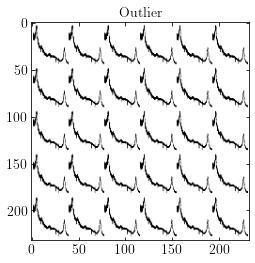

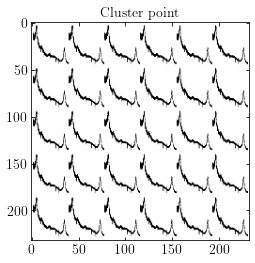

In [311]:
#STILL NOT WORKING

#now recover the name of the outlier plots
#take the first one in outliers right now
#t, fnames = create_dataset("spectra")
name = fnames[outliers_idx[rand_i[0]]]
print(name)
plt.figure()
plt.title('Outlier')
img = Image.open("spectra/"+name)
img = np.array(img)
plt.imshow(img)

#print first cluster point image
file = fnames[points_idx[points_i[0]]]
print(file)
plt.figure()
plt.title('Cluster point')
img2 = Image.open("spectra/"+file)
img2 = np.array(img2)
plt.imshow(img2)

In [468]:
def streamline(X_train, lr, perp, n_iter, min_samples, eps):
    predictions = autoencoder.predict(X_train)
    encodings = encoder.predict(X_train)
    
    #encode input data
    tsne = TSNE(n_components=2,learning_rate=lr, perplexity=perp, n_iter=n_iter)
    X_reduced = tsne.fit_transform(encodings)

    #t-SNE
    plt.title('t-SNE Reduced Components')
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.scatter(X_reduced[:,0], X_reduced[:,1], c="k", edgecolor="None")
    plt.savefig('tsne_lr%d_perp%d_iter%d.pdf' % (lr, perp, n_iter))
    plt.show()
    
    #DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_reduced)
    fig = plot_dbscan(db, X_reduced, size=100)
    fig.savefig('dbscan_5_eps%d_min%d_1.pdf' % (best_eps, best_min_samples))
    plt.show()
    n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    n_noise_ = list(db.labels_).count(-1)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of outliers from any cluster: %d" % n_noise_)
    print("Silhouette Coefficient: %0.3f" % silhouette_score(X_reduced, db.labels_))
    
    #plot outliers and samples of clusters
    outliers, outliers_idx = [], []
    for i, lab in enumerate(db.labels_):
        if lab == -1:
            outliers.append(predictions[i])
            outliers_idx.append(i)

    #plot random 5 outliers
    if len(outliers) > 0:
        rand_i = np.random.randint(0, len(outliers), size=5)
        print("rand_i", rand_i)
        fig, ax = plt.subplots(ncols=5, figsize=(16,5))
        fig.suptitle('Training Images Flagged as Outliers by DBSCAN')
        for idx, i in enumerate(rand_i):   
            ax[idx].imshow(outliers[i])
            adjust_spines(ax[idx], [])
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)
        plt.savefig('dbscan_eps%f_min%d_outliers.pdf' % (eps, min_samples))
        plt.show()

    cluster0, cluster0_idx = [], []
    for i, lab in enumerate(db.labels_):
        if lab != 0:
            cluster0.append(predictions[i])
            cluster0_idx.append(i)
    cluster0_i = np.random.randint(0, len(cluster0), size=5)
    fig, ax = plt.subplots(ncols=5, figsize=(16,5))
    fig.suptitle('Training Images in DBSCAN Cluster 0')
    for idx, i in enumerate(cluster0_i):   
        ax[idx].imshow(cluster0[i])
        adjust_spines(ax[idx], [])
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.savefig('dbscan_eps%f_min%d_cluster0.pdf' % (eps, min_samples))
    plt.show()

    cluster1, cluster1_idx = [], []
    for i, lab in enumerate(db.labels_):
        if lab != 0:
            cluster1.append(predictions[i])
            cluster1_idx.append(i)
    cluster1_i = np.random.randint(0, len(cluster0), size=5)
    fig, ax = plt.subplots(ncols=5, figsize=(16,5))
    fig.suptitle('Training Images in DBSCAN Cluster 1')
    for idx, i in enumerate(cluster1_i):   
        ax[idx].imshow(cluster1[i])
        adjust_spines(ax[idx], [])
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.savefig('dbscan_eps%f_min%d_cluster1.pdf' % (eps, min_samples))
    plt.show()